In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from noise import pnoise2
from perlin_noise import PerlinNoise

In [ ]:
# import cv2
# import numpy as np

# # Read the input image
# img = cv2.imread('l-system-3-iterations.png', 0)
# plt.imshow(img)

# # Define the kernel
# kernel = np.ones((5, 5), np.uint8)

# # Apply dilation
# img_dilation = cv2.erode(img, kernel, iterations=1)

# plt.imshow(img_dilation)

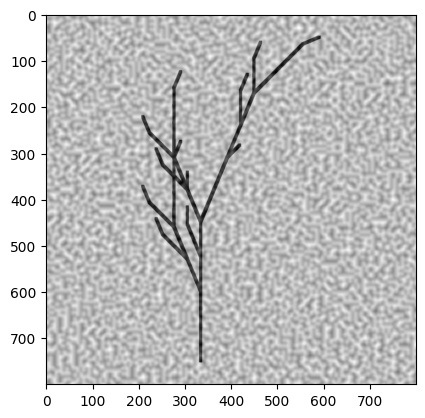

In [15]:
# Generate a 2D grid of Perlin noise
image = cv2.imread('l-system-3-iterations-dilated.png', cv2.IMREAD_GRAYSCALE)
height, width = image.shape

scale = 12
grid = [[pnoise2(i/scale, j/scale, octaves = 4, persistence = 0.01, lacunarity = 3) for j in range(height)] for i in range(width)]
grid = np.array(grid)

perlin_noise = cv2.normalize(grid, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
noisy_image = cv2.addWeighted(image, 0.5, perlin_noise, 0.5, 0)
# Visualize the noise
plt.imshow(noisy_image, cmap='gray')

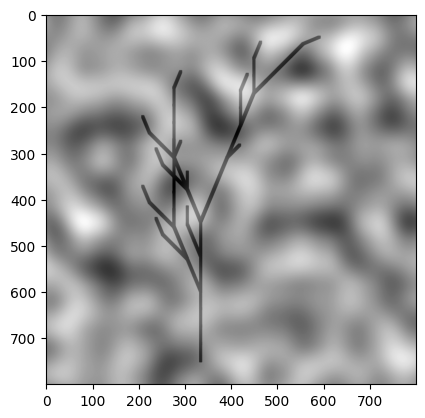

In [16]:
noise = PerlinNoise(octaves=8, seed=42)

grid = [[noise([i/width, j/height]) for j in range(height)] for i in range(width)]
grid = np.array(grid)
perlin_noise = cv2.normalize(grid, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
noisy_image = cv2.addWeighted(image, 0.3, perlin_noise, 0.7, 0)
plt.imshow(noisy_image, cmap='gray')

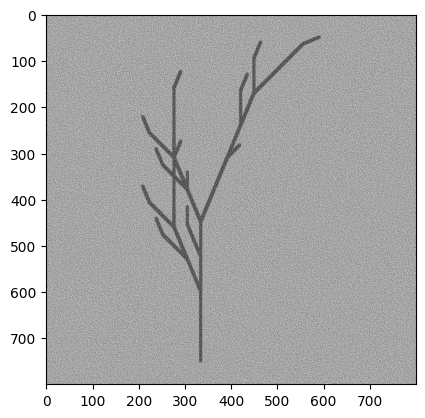

In [18]:
import opensimplex
opensimplex.seed(42)

grid = [[opensimplex.noise2(i, j) for j in range(height)] for i in range(width)]
grid = np.array(grid)
simplex_noise = cv2.normalize(grid, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
noisy_image = cv2.addWeighted(image, 0.3, simplex_noise, 0.7, 0)
plt.imshow(noisy_image, cmap='gray')
# n = opensimplex.noise2(x=10, y=10)
# print(n)

total time : 1.141897439956665 seconds


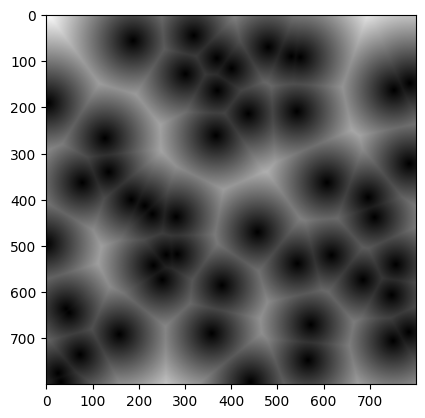

In [19]:
import time
import numpy as np
import matplotlib.pyplot as plt


class Point2D:
    def __init__(self, x, y):
        self.p = [x, y]

    def x(self):
        return (self.p[0])

    def y(self):
        return (self.p[1])

    def distance(point1, point2):
        import math
        return (math.sqrt((point1.x() - point2.x()) ** 2 + (point1.y() - point2.y()) ** 2))

    def getDistances(origin, li: list):
        distances = []
        for ll in li:
            distances.append(Point2D.distance(origin, Point2D(ll[0], ll[1])))
        return (distances)


class WorleyNoise:

    def __init__(self, height, width, density):

        self.height = height
        self.width = width
        self.density = density

    def auto(self, option):

        self.generatePoints()
        start = time.time()
        self.broadcastCalculateNoise(option)
        end = time.time()
        print("total time : " + str(end - start) + " seconds")
        self.showNoise()

    def generatePoints(self):
        self.points = []
        for _ in range(self.density):
            self.points.append([np.random.randint(0, self.width, 1)[0], np.random.randint(0, self.height, 1)[0]])

    def showPoints(self):
        plt.scatter([self.points[i][0] for i in range(len(self.points))],
                    [self.points[l][1] for l in range(len(self.points))])
        plt.show()

    def broadcastCalculateNoise(self, option):
        # casting points to numpy, it is of shape (nb_point, 2)
        points = np.array(self.points)
        # simple array of x and y coordinates for each coordinate
        xs = np.arange(self.width)
        ys = np.arange(self.height)
        # use the previously computed xs to get point.x - x for each x
        # notice the use of np.newaxis to control the broadcasting of the result to
        # an array of shape (nb_point, width)
        x_dist = np.power(points[:, 0, np.newaxis] - xs, 2)
        # same for ys, giving a (nb_point, height) shaped array
        y_dist = np.power(points[:, 1, np.newaxis] - ys, 2)
        # use the two last array to compute distance : sqrt((p.x - x) ** 2 + (.y - y ) ** 2))
        d = np.sqrt(x_dist[:, :, np.newaxis] + y_dist[:, np.newaxis, :])
        # d is of shape (nb_point, width, height), but we must sort it along the first axis
        distances = np.sort(d, axis=0)
        self.data = distances[option]

    def showNoise(self):
        import matplotlib.pyplot as plt
        plt.imshow(self.data, cmap="gray")
        plt.show()


w = WorleyNoise(height=height, width=width, density=50)
w.auto(0)

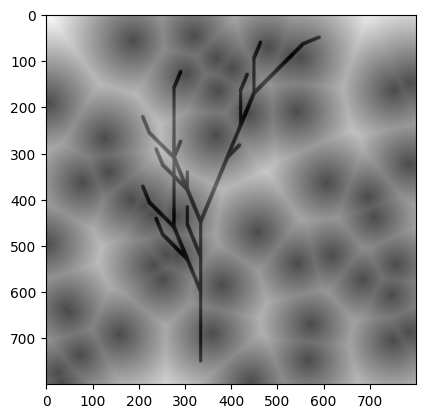

In [24]:
worley_noise = cv2.normalize(w.data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
noisy_image = cv2.addWeighted(image, 0.3, worley_noise, 0.7, 0)
plt.imshow(noisy_image, cmap='gray')

In [ ]:
import numpy as np
import random

# Define patch size and actions
PATCH_SIZE = 5
ACTIONS = ['N', 'S', 'E', 'W', 'NE', 'NW', 'SE', 'SW']
ACTION_MAP = {
    'N': (-1, 0), 'S': (1, 0), 'E': (0, 1), 'W': (0, -1),
    'NE': (-1, 1), 'NW': (-1, -1), 'SE': (1, 1), 'SW': (1, -1)
}

# Initialize Q-table: Q[(x, y)][action] = value
Q = {(x, y): {a: 0.0 for a in ACTIONS} for x in range(PATCH_SIZE) for y in range(PATCH_SIZE)}

# Sample patch: 0 = unexplored path, 1 = explored path, 2 = non-path
patch = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=int)
# You can manually set some non-path pixels for testing
patch[0, 0] = 2
patch[4, 4] = 2

# Hyperparameters
alpha = 0.1      # Learning rate
gamma = 0.9      # Discount factor
epsilon = 0.2    # Exploration rate
episodes = 1000
max_steps = 50

def is_valid(pos):
    x, y = pos
    return 0 <= x < PATCH_SIZE and 0 <= y < PATCH_SIZE

def get_reward(pos):
    x, y = pos
    if not is_valid(pos):
        return -1
    if patch[x, y] == 2:
        return -1
    elif patch[x, y] == 0:
        return 1
    else:
        return 0

def update_patch(pos):
    x, y = pos
    if is_valid(pos) and patch[x, y] == 0:
        patch[x, y] = 1

# Training loop
for episode in range(episodes):
    x, y = random.randint(0, PATCH_SIZE - 1), random.randint(0, PATCH_SIZE - 1)
    for step in range(max_steps):
        state = (x, y)

        # ε-greedy action selection
        if random.random() < epsilon:
            action = random.choice(ACTIONS)
        else:
            action = max(Q[state], key=Q[state].get)

        dx, dy = ACTION_MAP[action]
        next_state = (x + dx, y + dy)
        reward = get_reward(next_state)

        # Q-learning update
        if is_valid(next_state):
            max_next_q = max(Q[next_state].values())
        else:
            max_next_q = 0

        Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])

        # Update environment
        update_patch(next_state)

        # Move agent
        if is_valid(next_state):
            x, y = next_state

# Print learned Q-values for inspection
for state in Q:
    print(f"State {state}: {Q[state]}")